In [1]:
#!pip install --upgrade fused
import fused
fused._env('prod')
fused.options.show.show_widget = False
fused.options.request_timeout = 180

In [2]:
#from fused import NotebookCredentials
#credentials = fused.api.NotebookCredentials()

In [3]:
# from huggingface_hub import notebook_login
# notebook_login()

In [4]:
import torch
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torchvision
import torchvision.transforms.v2 as v2
from torchvision.transforms import InterpolationMode
import torchvision.transforms.functional as F
import numpy as np
import random
import cv2
from PIL import Image

In [5]:
from datasets import Dataset, load_dataset, concatenate_datasets
ds = load_dataset("gdurkin/s1_nlcd_ca",verification_mode='no_checks') #"gdurkin/s1_nlcd_sfbay_plus" "gdurkin/s1_nlcd_ca"
ds_merged = concatenate_datasets([ds[k] for k in list(ds.keys())])
ds_split = ds_merged.train_test_split(test_size=0.1, seed=42)
dataset_train = ds_split['train'] #,download_mode = "force_redownload")['train']
dataset_test = ds_split['test'] #,download_mode = "force_redownload")['train']

In [6]:
import numpy as np

# Original NLCD class labels and their descriptions
nlcd_class_color_dict = {
    11: 'Open Water',
    12: 'Perennial Ice/Snow',
    21: 'Developed, Open Space',
    22: 'Developed, Low Intensity',
    23: 'Developed, Medium Intensity',
    24: 'Developed, High Intensity',
    31: 'Barren Land (Rock/Sand/Clay)',
    41: 'Deciduous Forest',
    42: 'Evergreen Forest',
    43: 'Mixed Forest',
    52: 'Shrub/Scrub',
    71: 'Grassland/Herbaceous',
    81: 'Pasture/Hay',
    82: 'Cultivated Crops',
    90: 'Woody Wetlands',
    95: 'Emergent Herbaceous Wetlands'
}

# Sort the original class labels
original_labels = sorted(nlcd_class_color_dict.keys())

# Create mappings
label_mapping = {original_label: idx for idx, original_label in enumerate(original_labels)}
inverse_label_mapping = {idx: original_label for idx, original_label in enumerate(original_labels)}
num_classes = len(label_mapping)

# Create id2label and label2id dictionaries
id2label = {idx: nlcd_class_color_dict[original_label] for idx, original_label in enumerate(original_labels)}
label2id = {v: k for k, v in id2label.items()}


def remap_labels(label, label_mapping):
    # label: tensor of shape (H, W)
    label_np = label.numpy()
    label_np[label_np>95] = 12
    remapped_label_np = np.full_like(label_np, fill_value=255)  # Initialize with 255
    for original_label, new_label in label_mapping.items():
        remapped_label_np[label_np == original_label] = new_label
    return torch.from_numpy(remapped_label_np)


def adjust_gamma(image, gamma=1.0):
    # image: np.array (H,W,C) in uint8
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
                      for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(np.array(image, 'uint8'), table)

def prep_dataset_train(examples, target_size=240, p_hflip=0.3, p_vflip=0.3, gamma_base  = 0.65):
    """
    Preprocessing function for training dataset.
    
    Args:
        examples (dict): A batch of examples from the dataset.
        target_size (int): Desired size for resizing.
        p_hflip (float): Probability of horizontal flip.
        p_vflip (float): Probability of vertical flip.

    Returns:
        dict: Transformed batch with 'pixel_values' and 'labels'.
    """

    # Define transforms that do not include random flips or intensity
    # We will do flips and intensity modifications manually.
    image_transform = v2.Compose([
        v2.Resize((target_size, target_size), interpolation=InterpolationMode.BILINEAR),
        v2.PILToTensor(),
        v2.ToDtype(torch.float32, scale=True),
    ])

    label_transform = v2.Compose([
        v2.Resize((target_size, target_size), interpolation=InterpolationMode.NEAREST),
        v2.PILToTensor(),
        v2.Lambda(lambda x: x.squeeze(0)),  # Remove channel dimension if present
        v2.Lambda(lambda x: remap_labels(x, label_mapping)),
        v2.Lambda(lambda x: x.long()),  # Ensure labels are integers
    ])

    images = examples['pixel_values']
    labels = examples['labels']

    out_images = []
    out_labels = []

    for img, lbl in zip(images, labels):
        # Convert to PIL if tensor or array
        if torch.is_tensor(img) or isinstance(img, np.ndarray):
            img = v2.ToPILImage()(img)
        if torch.is_tensor(lbl) or isinstance(lbl, np.ndarray):
            lbl = v2.ToPILImage()(lbl)

        # Apply random horizontal flip to both image and label
        if random.random() < p_hflip:
            img = F.hflip(img)
            lbl = F.hflip(lbl)

        # Apply random vertical flip to both image and label
        if random.random() < p_vflip:
            img = F.vflip(img)
            lbl = F.vflip(lbl)

        # Random brightness factor: ±10%
        brightness_factor = random.uniform(0.9, 1.1)
        # Random gamma factor: ±10%
        gamma_factor = random.uniform(0.9, 1.1)

        # Convert image to numpy for brightness/gamma adjustments
        img_array = np.array(img, dtype='uint8')

        # Apply gamma correction
        if gamma_factor != 1.0:
            img_array = adjust_gamma(img_array, gamma=gamma_factor*gamma_base)

        # Apply brightness adjustment
        if brightness_factor != 1.0:
            # multiply all pixel values by brightness_factor and clip
            img_array = np.clip(img_array * brightness_factor, 0, 255).astype('uint8')

        # Convert back to PIL Image after adjustments
        img = Image.fromarray(img_array)

        # Now apply the resizing and tensor conversions
        img = image_transform(img)
        lbl = label_transform(lbl)

        out_images.append(img)
        out_labels.append(lbl)

    encoding = {}
    encoding["pixel_values"] = out_images  # List of tensors
    encoding["labels"] = out_labels        # List of tensors

    return encoding

def prep_dataset_validate(examples, target_size=240):
    """
    Preprocessing function for validation dataset.
    
    Args:
        examples (dict): A batch of examples from the dataset.
        target_size (int): Desired size for resizing.
    
    Returns:
        dict: Transformed batch with 'pixel_values' and 'labels'.
    """
    # Transforms for input images
    image_transform = v2.Compose([
        v2.ToPILImage(),
        v2.Resize((target_size, target_size), interpolation=InterpolationMode.BILINEAR),
        v2.PILToTensor(),
        v2.ToDtype(torch.float32, scale=True),
    ])

    # Transforms for target images
    label_transform = v2.Compose([
        v2.ToPILImage(),
        v2.Resize((target_size, target_size), interpolation=InterpolationMode.NEAREST),
        v2.PILToTensor(),
        v2.Lambda(lambda x: x.squeeze(0)),
        v2.Lambda(lambda x: remap_labels(x, label_mapping)),
        v2.Lambda(lambda x: x.long()),
    ])

    # Apply transforms
    images = [image_transform(x) for x in examples['pixel_values']]
    labels = [label_transform(y) for y in examples['labels']]

    encoding = {}
    encoding["pixel_values"] = images  # List of tensors
    encoding['labels'] = labels        # List of tensors
    return encoding


# Set the transforms with the desired target size (default is 240)
dataset_train.set_transform(lambda examples: prep_dataset_train(examples, target_size=240))
dataset_test.set_transform(lambda examples: prep_dataset_validate(examples, target_size=240))


In [7]:
id2label

{0: 'Open Water',
 1: 'Perennial Ice/Snow',
 2: 'Developed, Open Space',
 3: 'Developed, Low Intensity',
 4: 'Developed, Medium Intensity',
 5: 'Developed, High Intensity',
 6: 'Barren Land (Rock/Sand/Clay)',
 7: 'Deciduous Forest',
 8: 'Evergreen Forest',
 9: 'Mixed Forest',
 10: 'Shrub/Scrub',
 11: 'Grassland/Herbaceous',
 12: 'Pasture/Hay',
 13: 'Cultivated Crops',
 14: 'Woody Wetlands',
 15: 'Emergent Herbaceous Wetlands'}

In [8]:
nlcd_class_colors = {
    'Open Water': '#466B9F',
    'Perennial Ice/Snow': '#D1DDF9',
    'Developed, Open Space': '#DEC5C5',
    'Developed, Low Intensity': '#D99282',
    'Developed, Medium Intensity': '#EB0000',
    'Developed, High Intensity': '#AB0000',
    'Barren Land (Rock/Sand/Clay)': '#B3AC9F',
    'Deciduous Forest': '#68AB5F',
    'Evergreen Forest': '#1C5F2C',
    'Mixed Forest': '#B5C58F',
    'Shrub/Scrub': '#AF963C',
    'Grassland/Herbaceous': '#DFDFB0',
    'Pasture/Hay': '#D1D182',
    'Cultivated Crops': '#A3CC51',
    'Woody Wetlands': '#82C292',
    'Emergent Herbaceous Wetlands': '#C8E6C9'
}

In [9]:
def hex_to_rgb(hexa):
    return tuple(int(hexa[i+1:i+3], 16)  for i in (0, 2, 4))
id2color = dict([(k,hex_to_rgb(nlcd_class_colors[v])) for k,v in id2label.items()])
id2color

{0: (70, 107, 159),
 1: (209, 221, 249),
 2: (222, 197, 197),
 3: (217, 146, 130),
 4: (235, 0, 0),
 5: (171, 0, 0),
 6: (179, 172, 159),
 7: (104, 171, 95),
 8: (28, 95, 44),
 9: (181, 197, 143),
 10: (175, 150, 60),
 11: (223, 223, 176),
 12: (209, 209, 130),
 13: (163, 204, 81),
 14: (130, 194, 146),
 15: (200, 230, 201)}

In [10]:
original_id2color = dict([(k,hex_to_rgb(nlcd_class_colors[v])) for k,v in nlcd_class_color_dict.items()]) 
original_id2color

{11: (70, 107, 159),
 12: (209, 221, 249),
 21: (222, 197, 197),
 22: (217, 146, 130),
 23: (235, 0, 0),
 24: (171, 0, 0),
 31: (179, 172, 159),
 41: (104, 171, 95),
 42: (28, 95, 44),
 43: (181, 197, 143),
 52: (175, 150, 60),
 71: (223, 223, 176),
 81: (209, 209, 130),
 82: (163, 204, 81),
 90: (130, 194, 146),
 95: (200, 230, 201)}

In [11]:
def hex_to_rgb_float(hexa):
    return tuple((1/255.)*int(hexa[i+1:i+3], 16)  for i in (0, 2, 4))
name2color= dict([(k,hex_to_rgb_float(v)) for k,v in nlcd_class_colors.items()])
name2color

{'Open Water': (0.27450980392156865, 0.4196078431372549, 0.6235294117647059),
 'Perennial Ice/Snow': (0.8196078431372549,
  0.8666666666666667,
  0.9764705882352941),
 'Developed, Open Space': (0.8705882352941177,
  0.7725490196078432,
  0.7725490196078432),
 'Developed, Low Intensity': (0.8509803921568627,
  0.5725490196078431,
  0.5098039215686274),
 'Developed, Medium Intensity': (0.9215686274509803, 0.0, 0.0),
 'Developed, High Intensity': (0.6705882352941176, 0.0, 0.0),
 'Barren Land (Rock/Sand/Clay)': (0.7019607843137254,
  0.6745098039215687,
  0.6235294117647059),
 'Deciduous Forest': (0.40784313725490196,
  0.6705882352941176,
  0.37254901960784315),
 'Evergreen Forest': (0.10980392156862745,
  0.37254901960784315,
  0.17254901960784313),
 'Mixed Forest': (0.7098039215686275, 0.7725490196078432, 0.5607843137254902),
 'Shrub/Scrub': (0.6862745098039216, 0.5882352941176471, 0.23529411764705882),
 'Grassland/Herbaceous': (0.8745098039215686,
  0.8745098039215686,
  0.690196078431

In [12]:
color2name = {v:k for k,v in name2color.items()}

In [13]:
import matplotlib as mpl
from matplotlib import colors
import matplotlib.pyplot as plt

# Order the class names by their assigned integer, ensuring a consistent ordering from 0 to 15.
class_names_in_order = [
    'Open Water',
    'Perennial Ice/Snow',
    'Developed, Open Space',
    'Developed, Low Intensity',
    'Developed, Medium Intensity',
    'Developed, High Intensity',
    'Barren Land (Rock/Sand/Clay)',
    'Deciduous Forest',
    'Evergreen Forest',
    'Mixed Forest',
    'Shrub/Scrub',
    'Grassland/Herbaceous',
    'Pasture/Hay',
    'Cultivated Crops',
    'Woody Wetlands',
    'Emergent Herbaceous Wetlands'
]

# Create a list of colors in the order of the classes
col_list = [nlcd_class_colors[name] for name in class_names_in_order]

# Create a discrete ListedColormap for NLCD classes
cmap_nlcd = colors.ListedColormap(col_list, name='nlcd_cmap')

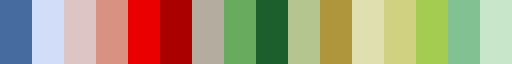

In [14]:
cmap_nlcd

In [15]:
if torch.backends.mps.is_built():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [16]:
device

device(type='mps')

In [17]:
#!pip install --upgrade torch torchvision

### Let's load our trained model for mapping sentinel 1 data to National LandCover Dataset (NLCD)

In [18]:
from transformers import Mask2FormerForUniversalSegmentation, Mask2FormerImageProcessor
from torch.utils.data import DataLoader

#model_dir = "gdurkin/s1_nlcd_mask2former_v2"
def MF_predict(img,model_dir=None):
    m2f_model = Mask2FormerForUniversalSegmentation.from_pretrained(model_dir,
    label2id=label2id,
    id2label = id2label,
    num_labels=len(id2label),
    ignore_mismatched_sizes=True,
)
    m2f_model = m2f_model.to(device)

    preprocessor = Mask2FormerImageProcessor(ignore_index=255, reduce_labels=False, do_resize=False, do_rescale=False, do_normalize=False)

    if isinstance(img, np.ndarray):
        img = torch.from_numpy(img).float()
    if torch.is_tensor(img):
        input_tensor = img
    else:
        input_tensor = pil_to_tensor(img)
    if len(input_tensor.shape)==3:
        input_tensor = input_tensor.unsqueeze(0)
    with torch.no_grad():
      outputs = m2f_model(input_tensor.to(device))
    target_sizes = [(input_tensor.shape[2],input_tensor.shape[3])]
    #print('target_sizes:',target_sizes)
    predicted_segmentation_maps = preprocessor.post_process_semantic_segmentation(outputs, target_sizes=target_sizes)
    return predicted_segmentation_maps[0].cpu().numpy().transpose(1,0)

/Users/gabriela.durkin/miniforge3/envs/aienv/lib/python3.11/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/Users/gabriela.durkin/miniforge3/envs/aienv/lib/python3.11/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/Users/gabriela.durkin/miniforge3/envs/aienv/lib/python3.11/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/Users/gabriela.durkin/miniforge3/envs/aienv/lib/python3.11/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree.

In [19]:
def vec_translate(a, my_dict):
    try:
        return np.array(np.vectorize(my_dict.__getitem__)(a)).transpose(1,2,0)
    except:
        return np.array(np.vectorize(my_dict.__getitem__)(a))

In [20]:
test_dataloader = DataLoader(dataset_test, batch_size=4, shuffle=True)

In [25]:
batch_test = next(iter(test_dataloader))

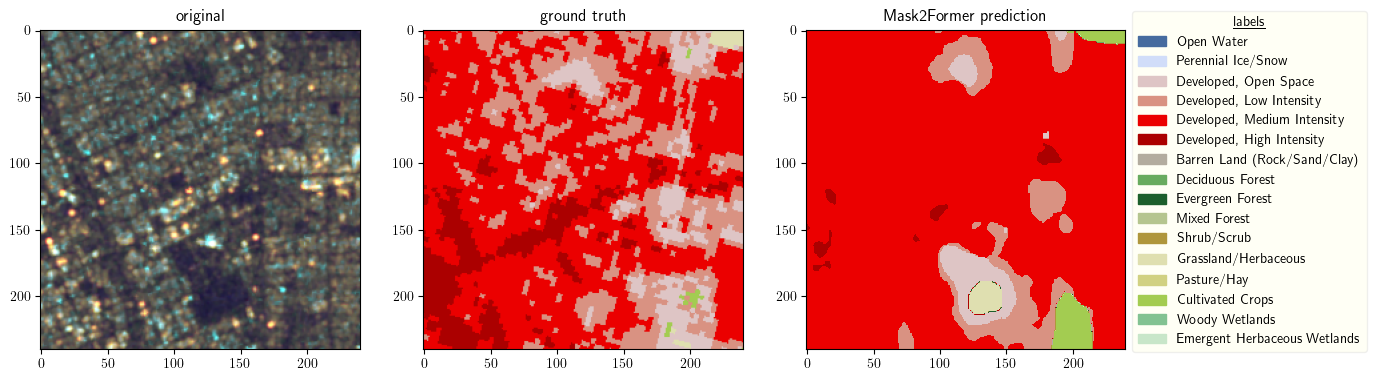

CPU times: user 1.94 s, sys: 1.2 s, total: 3.14 s
Wall time: 4.96 s


In [26]:
%%time
import matplotlib.patches as mpatches

ex = 0 #choose an example test tile

pixel_values = batch_test['pixel_values'][ex]
mask_values = np.array(batch_test['labels'][ex].cpu().transpose(0,-1).numpy())
test_img = np.array(255*pixel_values.cpu().transpose(0,-1),'uint8')
mask_values_color = vec_translate(mask_values, id2color)

m2f_pred = MF_predict(pixel_values,model_dir = "gdurkin/s1_nlcd_mask2former_v5")
mpl.rc('text', usetex=True)
mpl.rcParams['mathtext.fontset'] = 'stixsans'
mpl.rcParams['mathtext.rm'] = 'stixsans'
mpl.rcParams['mathtext.it'] = 'stixsans'
mpl.rcParams['mathtext.bf'] = 'stixsans'
fig, ax = plt.subplots(1,3,figsize = (14,10))
ax[0].imshow(test_img)
ax[1].imshow(mask_values_color)
ax[2].imshow(m2f_pred,cmap=cmap_nlcd,vmin = 0, vmax = 15)

ax[0].set_title('original')
ax[1].set_title('ground truth')
ax[2].set_title('Mask2Former prediction')

handles, labels = ax[2].get_legend_handles_labels()
for clr,crop in color2name.items():
    patch = mpatches.Patch(color=clr, label=crop)
    handles.append(patch)
ax[2].legend(handles=handles, loc='lower left', bbox_to_anchor=(1, -0.03),facecolor="lightyellow",framealpha = 0.3,title = r'$\underline{\mathsf{labels}}$') #

plt.show()

### let's try a large holdout ROI

In [27]:
from PIL import Image as Img
def bounds_to_img(user_email,udf_str,bounds,kw_dict,png_req=False):
    kw_dict_sup  = {'west':bounds[0], 
                     'south':bounds[1], 
                     'east':bounds[2], 
                     'north':bounds[3]}
    kw_dict_total = {**kw_dict_sup, **kw_dict}
    xarr = fused.run(user_email,udf_str,**kw_dict_total)
    try:
        img = np.transpose(np.array(xarr.image[0:3],'uint8'),(1,2,0))
    except:
        img = np.transpose(np.array(xarr[0].image[0:3],'uint8'),(1,2,0))
    if png_req:
        img = Img.fromarray(img)
    return img

In [28]:
bbox_holdout = [-122.53479,37.447936,-122.150269,37.641752]

holdout_dict = dict(gamma = 0.65,
        brightnesst = 1.4,
        year= 2022, 
        month = "06", 
        despeckle = True, 
        frac_power = 0.25,
       time_slice_count=1,
       zoom= 14,
        month_window = 1)

holdout_dict

{'gamma': 0.65,
 'brightnesst': 1.4,
 'year': 2022,
 'month': '06',
 'despeckle': True,
 'frac_power': 0.25,
 'time_slice_count': 1,
 'zoom': 14,
 'month_window': 1}

In [29]:
%%time
holdout_s1 = bounds_to_img("***@fused.io","S1_exp_bbox",bbox_holdout,
                            holdout_dict,png_req = False)

CPU times: user 418 ms, sys: 255 ms, total: 673 ms
Wall time: 35.8 s


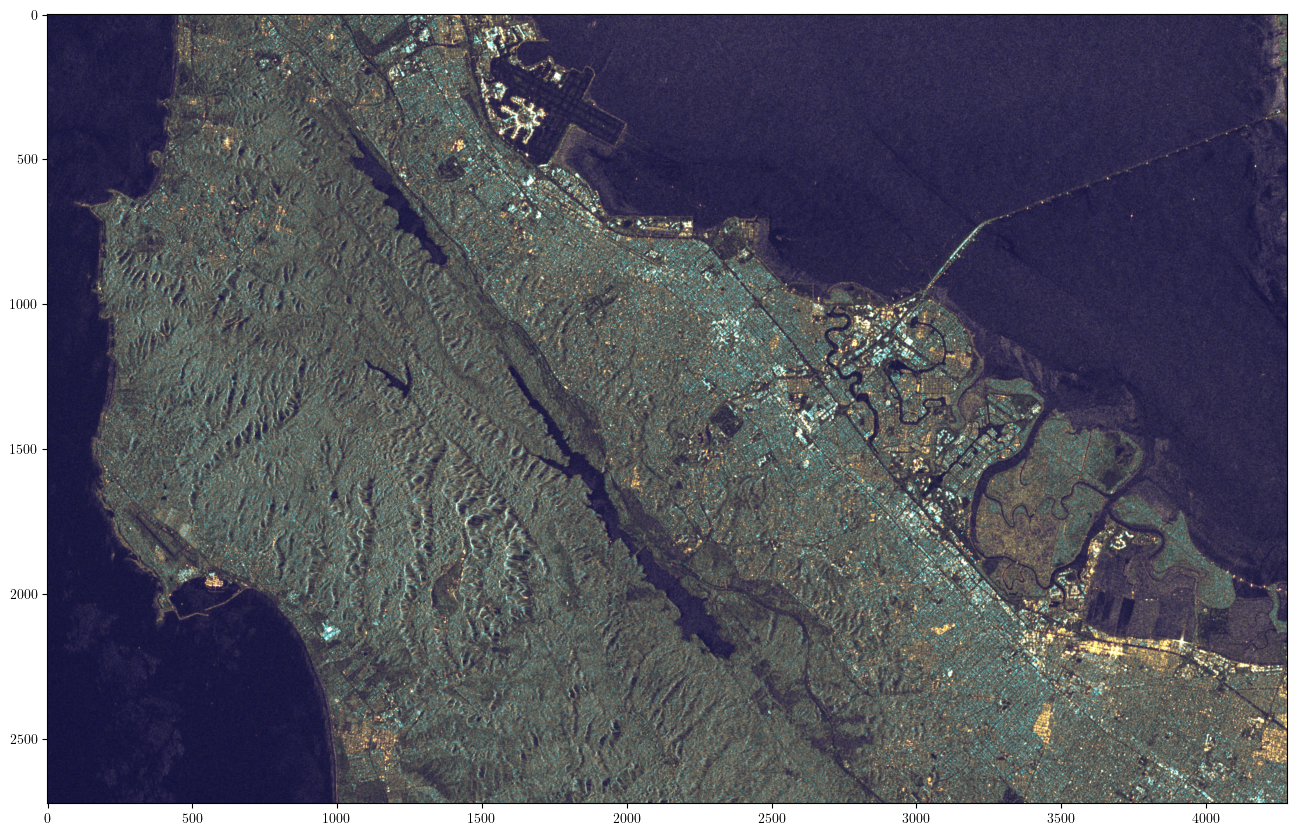

In [30]:
fig, ax = plt.subplots(figsize = (16,16))
plt.imshow(holdout_s1)

In [31]:
%%time
holdout_nlcd_dict = dict( 
        year = 2022, 
        zoom=14)
holdout_nlcd = bounds_to_img("***@fused.io","NLCD_bbox",bbox_holdout,holdout_nlcd_dict,png_req= False)

CPU times: user 65.4 ms, sys: 49.2 ms, total: 115 ms
Wall time: 4.36 s


In [32]:
np.unique(holdout_nlcd[:,:,0])

array([11, 12, 21, 22, 23, 24, 31, 41, 42, 43, 52, 71, 81, 82, 90, 95],
      dtype=uint8)

In [33]:
holdout_mod = holdout_nlcd[:,:,0]
holdout_mod[holdout_mod > 95] =12

In [34]:
holdout_nlcd_rgb =  vec_translate(holdout_mod, original_id2color)

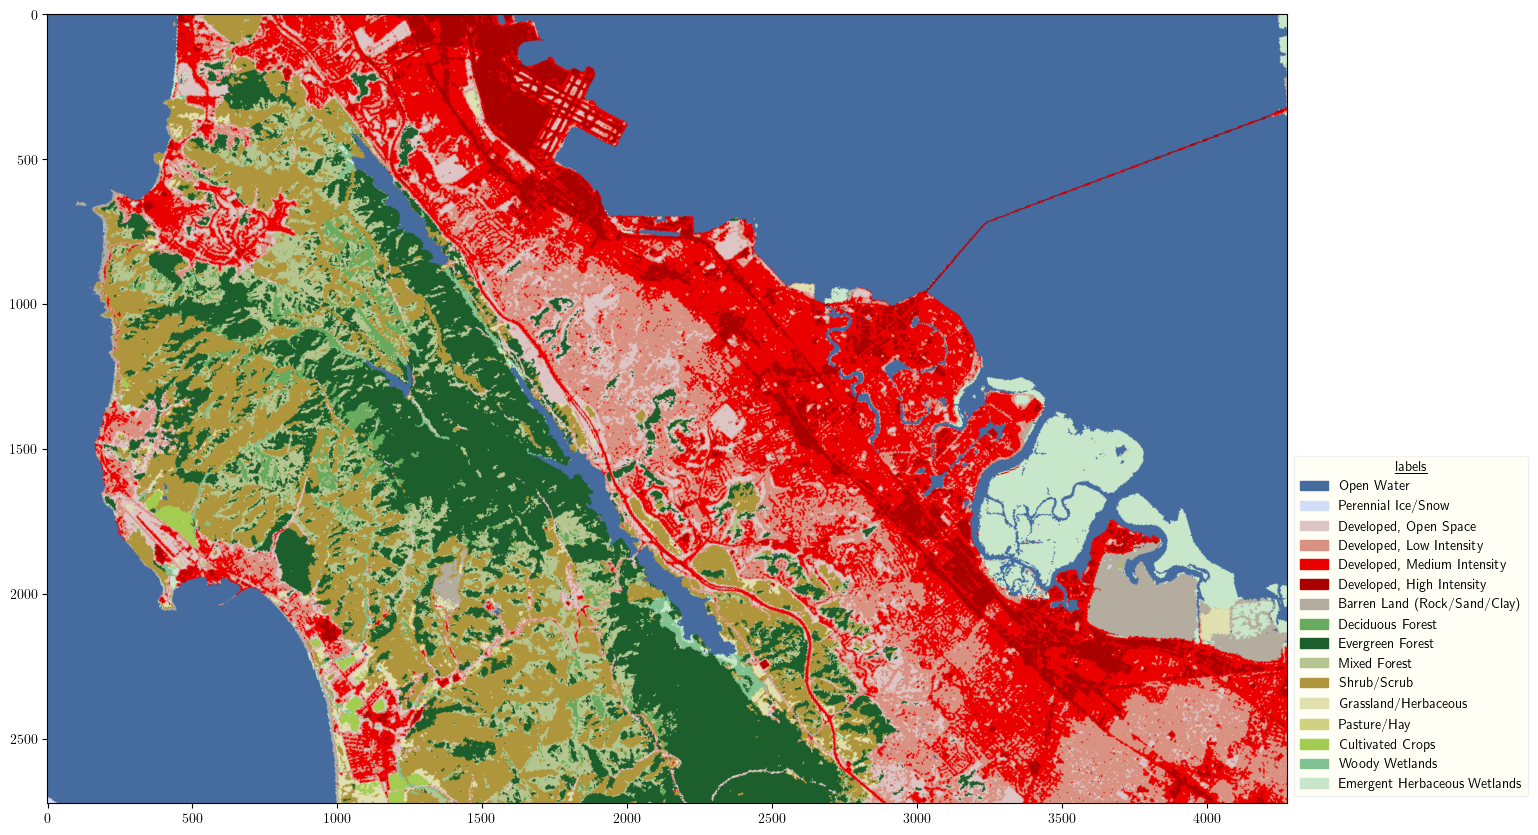

In [35]:
fig, ax = plt.subplots(figsize = (16,16))
plt.imshow(holdout_nlcd_rgb)
handles, labels = ax.get_legend_handles_labels()
for clr,crop in color2name.items():
    patch = mpatches.Patch(color=clr, label=crop)
    handles.append(patch)
ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(1, -0.0),facecolor="lightyellow",framealpha = 0.3,title = r'$\underline{\mathsf{labels}}$') #

plt.show()

In [36]:
import gc
import torch
import numpy as np
from PIL import Image
from itertools import product
from torchvision.transforms.functional import to_pil_image

model_dir_current = "gdurkin/s1_nlcd_mask2former_v5"

def pil_to_tensor(img):
    return v2.ToTensor()(img)

def to_pil_image(img):
    if torch.is_tensor(img):
        img = img.cpu().numpy().transpose(1, 2, 0).astype(np.uint8)
    if isinstance(img, np.ndarray):
        img = Image.fromarray(img)
    return img

    
def tile_and_predict(img_png, model, d=256, rot=0, model_type='UNet', simplify=True):
    # If img_png is a tensor or np.ndarray, convert it to PIL Image
    if torch.is_tensor(img_png) or isinstance(img_png, np.ndarray):
        img_png = to_pil_image(img_png)

    # Original image size
    w, h = img_png.size
    print('original image size:', w, h)

    # Crop the image so that both dimensions are multiples of d
    img_area = (0, 0, w - w % d, h - h % d)
    img_png = img_png.crop(img_area)
    ww, hh = img_png.size
    print('tiled image size:', ww, hh)

    # Create a grid of coordinates for tiling using the updated cropped dimensions (ww, hh)
    grid = product(range(0, hh, d), range(0, ww, d))

    tile_list = []
    k = 0

    for i, j in grid:
        box = (j, i, j + d, i + d)
        tile = img_png.crop(box)

        # Rotate tile before prediction
        rotated_tile = tile.transpose(Image.TRANSPOSE).rotate(rot)

        if model_type == 'UNet':
            pred_seg = UNET_predict(rotated_tile, model, layers_out=False, simplify=simplify)
        else:
            pred_seg = MF_predict(rotated_tile,model_dir = model_dir_current)

        # Rotate back predicted segmentation to the original orientation
        rot_factor = -1 * (rot // 90)
        corrected_seg = np.rot90(pred_seg, rot_factor)

        tile_list.append(corrected_seg)

        # Clear references
        pred_seg = None
        corrected_seg = None
        with torch.no_grad():
            torch.cuda.empty_cache()
            gc.collect()

        k += 1
        # Optional: print('Processed tile', k)

    # Convert the list of predicted tiles into a numpy array
    pred_array = np.array(tile_list)
    # pred_array shape: (N, d, d) where N = (hh//d)*(ww//d)

    # Reshape the array into the original image dimensions
    # First reshape to (hh//d, ww//d, d, d), then swap axes, then reshape to (hh, ww)
    tiles = pred_array.reshape(hh // d, ww // d, d, d) \
                      .swapaxes(1, 2) \
                      .reshape(hh, ww)

    return img_png, tiles

def tile_and_predict_with_buffer(
    img_png,
    model,
    d_inner=256,
    d_outer=960,
    rot=0,
    model_type='UNet',
    simplify=True
):

    if torch.is_tensor(img_png) or isinstance(img_png, np.ndarray):
        img_png = to_pil_image(img_png)

    # 2) Original image size
    W, H = img_png.size
    print("Original image size:", W, H)

    # 3) Crop so W,H are multiples of d_inner
    W_cropped = W - (W % d_inner)
    H_cropped = H - (H % d_inner)
    img_png = img_png.crop((0, 0, W_cropped, H_cropped))
    W, H = img_png.size
    print("Tiled image size:", W, H)

    # 4) Prepare the grid (stride d_inner)
    #    'top_y' in [0, d_inner, 2*d_inner,...], 'left_x' similarly
    
    grid = product(range(0, H, d_inner), range(0, W, d_inner))

    # 5) Max possible margin
    max_margin = (d_outer - d_inner) // 2 if d_outer > d_inner else 0

    tile_list = []

    # 6) For each tile in the grid
    for top_y, left_x in grid:
        # a) Compute how much we can expand upward/downward
        margin_top = min(max_margin, top_y)
        margin_bottom = min(max_margin, H - (top_y + d_inner))

        # b) Compute how much we can expand left/right
        margin_left = min(max_margin, left_x)
        margin_right = min(max_margin, W - (left_x + d_inner))

        # c) Crop the expanded tile from the original image
        top_expanded    = top_y - margin_top
        left_expanded   = left_x - margin_left
        bottom_expanded = top_y + d_inner + margin_bottom
        right_expanded  = left_x + d_inner + margin_right

        expanded_tile = img_png.crop((left_expanded, top_expanded,
                                      right_expanded, bottom_expanded))
        #expanded_tile =expanded_tile.transpose(Image.TRANSPOSE)
        
        if model_type == 'UNet':
            pred_seg = UNET_predict(expanded_tile, model, layers_out=False, simplify=simplify)
        else:
            pred_seg = MF_predict(expanded_tile, model_dir=model_dir_current)
        pred_seg =np.transpose(pred_seg)
        # pred_seg.shape => (expanded_height, expanded_width)

        # 7) Physically correct subregion:
        #    The reference tile's top-left corner is (left_x, top_y) in the original image.
        #    The expanded tile's top-left corner is (left_expanded, top_expanded).
        #    => local row_start = top_y - top_expanded
        #       local col_start = left_x - left_expanded
        row_start = top_y - top_expanded
        col_start = left_x - left_expanded

        row_end = row_start + d_inner  # exactly d_inner rows
        col_end = col_start + d_inner  # exactly d_inner cols

        # Slice that region out of pred_seg
        # If the expanded tile is smaller than (margin + d_inner), we might have to clamp or pad
        sub_seg = pred_seg[row_start:row_end, col_start:col_end]
        #sub_seg = pred_seg[margin_left:margin_left+d_inner, margin_top:margin_top+d_inner]

        # e) Zero-pad if sub_seg is smaller than (d_inner, d_inner)
        final_tile = np.zeros((d_inner, d_inner), dtype=sub_seg.dtype)
        h_slice, w_slice = sub_seg.shape
        final_tile[:h_slice, :w_slice] = sub_seg

        tile_list.append(final_tile)

        # Cleanup
        pred_seg = None
        sub_seg = None
        expanded_tile = None
        with torch.no_grad():
            torch.cuda.empty_cache()
            gc.collect()

    # 8) tile_list => shape (N, d_inner, d_inner),
    #    N = (H // d_inner)*(W // d_inner).
    pred_array = np.array(tile_list)

    # 9) Reshape => (H, W) exactly as your original code
    rows = H // d_inner
    cols = W // d_inner
    pred_array = pred_array.reshape(rows, cols, d_inner, d_inner)
    tiles = pred_array.swapaxes(1, 2).reshape(H, W)

    return img_png, tiles

### with larger input image (4282,2723) and using a large buffer of 960 pixels- a macbook air will struggle --> calculation may crash the kernel

In [ ]:
%%time
#m2f_predict_holdout = tile_and_predict(holdout_s1, None, d=960,rot=0,model_type='M2F')
m2f_predict_holdout = tile_and_predict_with_buffer(holdout_s1, None, d_outer=960, d_inner=240, model_type='M2F', simplify=True)
m2f_model_out = m2f_predict_holdout[1]

Original image size: 4282 2723
Tiled image size: 4080 2640


/Users/gabriela.durkin/miniforge3/envs/aienv/lib/python3.11/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/gabriela.durkin/miniforge3/envs/aienv/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [176]:
m2f_model_out_rgb =  vec_translate(m2f_model_out, id2color)

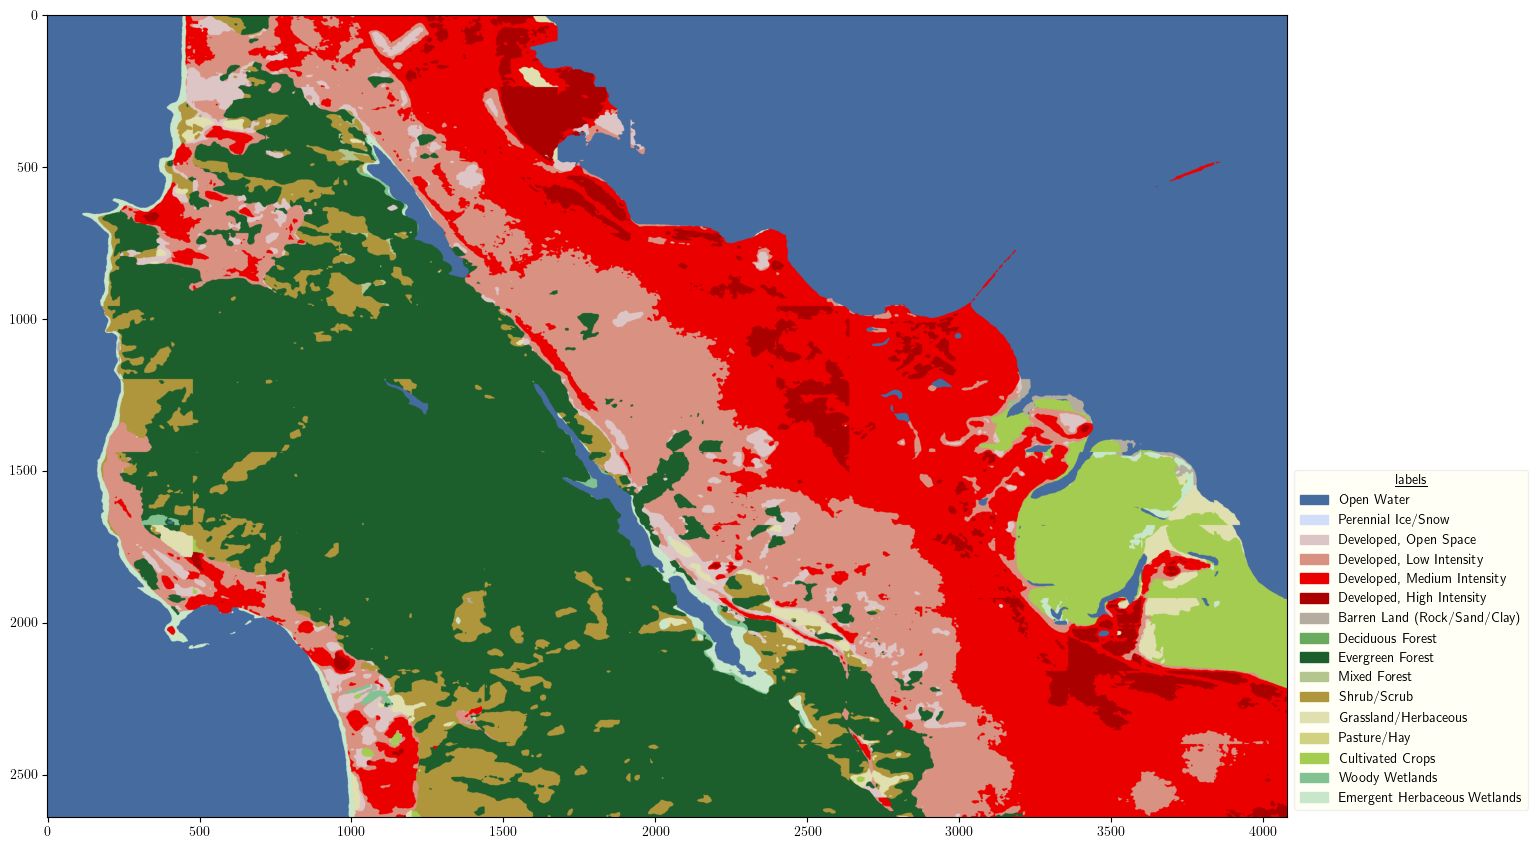

In [177]:
fig, ax = plt.subplots(figsize = (16,16))
plt.imshow(m2f_model_out_rgb)
handles, labels = ax.get_legend_handles_labels()
for clr,crop in color2name.items():
    patch = mpatches.Patch(color=clr, label=crop)
    handles.append(patch)
ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(1, -0.0),facecolor="lightyellow",framealpha = 0.3,title = r'$\underline{\mathsf{labels}}$') #


In [180]:
m2f_model_out.shape, holdout_mod.shape

((2640, 4080), (2721, 4278))

In [181]:
x, y = m2f_model_out.shape

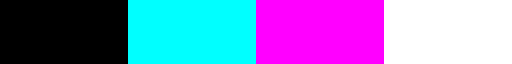

In [182]:
import matplotlib as mpl
from matplotlib import colors

def named_color_array(name_list = ['black','blue','grey','yellow','brown','moccasin','orange','darkgreen','limegreen','cyan']):
    return [colors.cnames[el] for el in name_list]

cmap_4col = mpl.colors.LinearSegmentedColormap.from_list('cdl_4col', named_color_array(name_list = ['black','cyan','magenta','white']),4)

cmap_4col

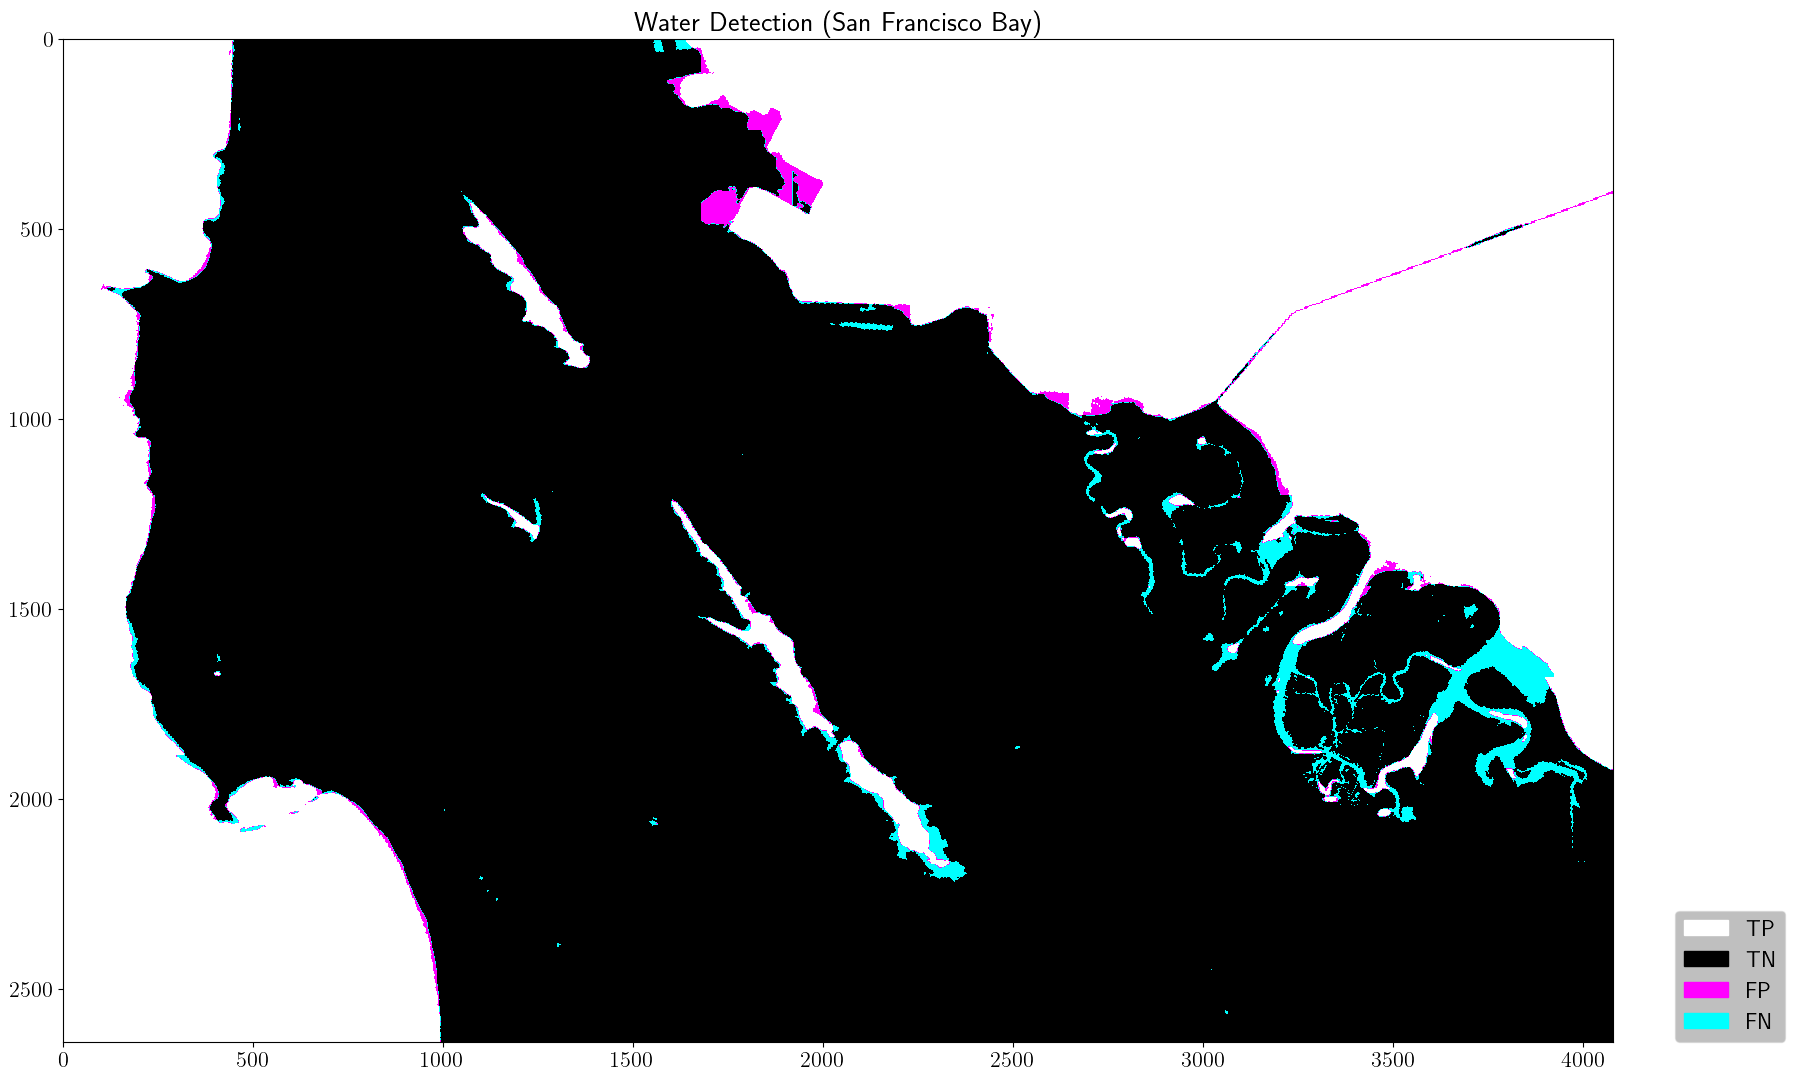

In [184]:
pred_mask = 1*m2f_model_out ==0 #water prediction

truth_mask = 1*holdout_mod[:x,:y]==11 #water truth
img_mask_co = truth_mask+ 2*pred_mask
mpl.rcParams['xtick.labelsize'] =16
mpl.rcParams['ytick.labelsize'] =16
fig, ax = plt.subplots(figsize = (20,20))
ax.imshow(img_mask_co, cmap=cmap_4col, vmin = 0,vmax = 3)
ax.set_title('Water Detection (San Francisco Bay)',size = 20)
TP_patch = mpatches.Patch(color='white', label='TP')
TN_patch = mpatches.Patch(color='black', label='TN')
FP_patch = mpatches.Patch(color='magenta', label='FP')
FN_patch = mpatches.Patch(color='cyan', label='FN')
plt.legend(handles=[TP_patch,TN_patch,FP_patch,FN_patch],fontsize = 16, loc=(1.04, 0),facecolor='grey', framealpha=0.5)

In [207]:
NLCD_COLORS = {
    11: {'color': (70, 107, 159), 'label': "Open Water",'model_label':0},
    12: {'color': (209, 222, 248), 'label': "Perennial Ice/Snow",'model_label':1},
    21: {'color': (222, 197, 197), 'label': "Dev, Open Space",'model_label':2},
    22: {'color': (217, 146, 130), 'label': "Dev, Low Intensity",'model_label':3},
    23: {'color': (235, 0, 0), 'label': "Dev, Med Intensity",'model_label':4},
    24: {'color': (171, 0, 0), 'label': "Dev, High Intensity",'model_label':5},
    31: {'color': (179, 172, 159), 'label': "Barren Land",'model_label':6},
    41: {'color': (104, 171, 95), 'label': "Deciduous Forest",'model_label':7},
    42: {'color': (28, 95, 44), 'label': "Evergreen Forest",'model_label':8},
    43: {'color': (181, 197, 143), 'label': "Mixed Forest",'model_label':9},
    52: {'color': (204, 184, 121), 'label': "Shrub/Scrub",'model_label':10},
    71: {'color': (223, 223, 194), 'label': "Herbaceous",'model_label':11},
    81: {'color': (220, 217, 57), 'label': "Hay/Pasture",'model_label':12},
    82: {'color': (171, 108, 40), 'label': "Cultivated Crops",'model_label':13},
    90: {'color': (184, 217, 235), 'label': "Woody Wetlands",'model_label':14},
    95: {'color': (108, 159, 184), 'label': "Emergent Herb. Wetlands",'model_label':15},
}



In [208]:
model_to_orig_dict = dict([[el[1]['model_label'],el[0]] for el in NLCD_COLORS.items()])
model_to_orig_dict

{0: 11,
 1: 12,
 2: 21,
 3: 22,
 4: 23,
 5: 24,
 6: 31,
 7: 41,
 8: 42,
 9: 43,
 10: 52,
 11: 71,
 12: 81,
 13: 82,
 14: 90,
 15: 95}

In [209]:
predict_array = vec_translate(m2f_model_out, model_to_orig_dict)
gt_array = holdout_mod[:x,:y]

In [210]:
np.unique(prediction)

array([11, 21, 22, 23, 24, 31, 42, 43, 52, 71, 82, 90, 95])

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def plot_nlcd_iou(gt_array, pred_array, NLCD_COLORS, size_tuple=(18,18)):
    """
    Plot IoU for each NLCD class code in a 4×4 grid of square diagrams.
    
    Parameters
    ----------
    gt_array : np.ndarray (H, W)
        Ground truth array of NLCD class codes (11, 12, 21, 22, ...)
    pred_array : np.ndarray (H, W)
        Predicted array of NLCD class codes, same shape as gt_array
    NLCD_COLORS : dict
        Dictionary mapping NLCD class code -> {'color': (R,G,B), 'label': "Some label"}
    size_tuple : tuple
        Figure size (width, height)
    """

    class_codes = sorted(NLCD_COLORS.keys())
    num_classes = len(class_codes)
    
    # Create a 4×4 figure (assuming up to 16 classes)
    fig, axes = plt.subplots(4, 4, figsize=size_tuple)
    axes = axes.ravel()
    fig.patch.set_facecolor('black')

    for idx, class_code in enumerate(class_codes):
        ax = axes[idx]
        ax.set_facecolor('black')

        # Extract color and label
        class_info = NLCD_COLORS[class_code]
        color_rgb = class_info['color']
        label = class_info['label']

        # Ground truth and prediction masks
        gt_mask = (gt_array == class_code)
        pred_mask = (pred_array == class_code)

        # Pixel counts
        gt_count = np.count_nonzero(gt_mask)
        pred_count = np.count_nonzero(pred_mask)
        intersection_count = np.count_nonzero(gt_mask & pred_mask)
        union_count = gt_count + pred_count - intersection_count
        iou = 100 * intersection_count / union_count if union_count > 0 else 0.0

        # Label below the subplot
        ax.text(
            0.5, -0.05,
            label,
            ha='center',
            va='top',
            fontsize=18,
            color='white',
            transform=ax.transAxes
        )

        # Show IoU value in the center
        ax.text(
            0.5, 0.5,
            f"IoU: {iou:.2f}%",
            ha='center',
            va='center',
            fontsize=26,
            color='white',
            weight='bold',
            transform=ax.transAxes
        )

        # Show GT pixel count in bottom-right
        ax.text(
            0.95, 0.05,
            f"{gt_count}",
            ha='right',
            va='bottom',
            fontsize=14,
            color='white',
            transform=ax.transAxes
        )

        # If no pixels in GT or Pred, skip drawing squares
        if gt_count == 0 or pred_count == 0:
            ax.axis('off')
            continue

        # "Square area" illustration
        scale_factor = 10.0
        side_len_gt = np.sqrt(gt_count * scale_factor)
        side_len_pred = np.sqrt(pred_count * scale_factor)
        overlap_area = intersection_count * scale_factor
        side_len_overlap = np.sqrt(overlap_area)

        # Draw the GT square
        gt_square = plt.Rectangle(
            (0, 0),
            side_len_gt, side_len_gt,
            edgecolor=np.array(color_rgb)/255.0,
            facecolor=np.array(color_rgb)/255.0,
            alpha=0.5,
            linewidth=1
        )
        ax.add_patch(gt_square)

        # Position the predicted square
        pred_x = side_len_gt - side_len_overlap
        pred_y = side_len_gt - side_len_overlap

        pred_square = plt.Rectangle(
            (pred_x, pred_y),
            side_len_pred, side_len_pred,
            edgecolor=np.array(color_rgb)/255.0,
            facecolor=np.array(color_rgb)/255.0,
            alpha=0.5,
            linewidth=1
        )
        ax.add_patch(pred_square)

        # Small text for "GT" and "ML"
        ax.text(
            0, 0,
            "GT",
            ha='left',
            va='bottom',
            fontsize=14,
            color='white'
        )
        ax.text(
            pred_x + side_len_pred, pred_y + side_len_pred,
            "ML",
            ha='right',
            va='top',
            fontsize=14,
            color='white'
        )

        # Adjust limits
        max_x = max(side_len_gt, pred_x + side_len_pred)
        max_y = max(side_len_gt, pred_y + side_len_pred)
        ax.set_xlim(-0.5, max_x + 1)
        ax.set_ylim(-0.5, max_y + 1)
        ax.set_aspect('equal')
        ax.axis('off')

    # Turn off any extra subplots
    for idx_extra in range(num_classes, 16):
        axes[idx_extra].axis('off')

    fig.suptitle("NLCD IoU Plot", color='white', fontsize=32)
    plt.tight_layout()
    return fig
# def plot_nlcd_iou(gt_array, pred_array, NLCD_COLORS,size_tuple = (18,18)):
#     """
#     Plot IoU for each NLCD class code in a 4×4 grid of square diagrams.
    
#     Parameters
#     ----------
#     gt_array : np.ndarray (H, W)
#         Ground truth array of NLCD class codes (11, 12, 21, 22, ...)
#     pred_array : np.ndarray (H, W)
#         Predicted array of NLCD class codes, same shape as gt_array
#     NLCD_COLORS : dict
#         Dictionary mapping NLCD class code -> {'color': (R,G,B), 'label': "Some label"}
#         Example:
#             {
#                 11: {'color': (70, 107, 159),  'label': "Open Water"},
#                 12: {'color': (209, 222, 248), 'label': "Perennial Ice/Snow"},
#                 ... (16 total classes) ...
#             }
#     Returns
#     -------
#     fig : matplotlib Figure
#         The generated figure for display or saving.
#     """

#     # Sort the NLCD class codes so they're in ascending order
#     class_codes = sorted(NLCD_COLORS.keys())  # e.g., [11, 12, 21, 22, ..., 95]
#     num_classes = len(class_codes)
#     if num_classes != 16:
#         print(f"Warning: Expected 16 classes, found {num_classes}. You can still proceed, but the grid layout is 4×4.")
    
#     # Create a 4×4 figure (assuming we have 16 classes)
#     fig, axes = plt.subplots(4, 4, figsize=size_tuple)

#     # Convert to 1D for iteration convenience in case there's fewer/more than 16
#     axes = axes.ravel()

#     # For consistent visuals, set a black background
#     fig.patch.set_facecolor('black')

#     # We'll iterate over each class code
#     for idx, class_code in enumerate(class_codes):
#         ax = axes[idx]  # The subplot for this class code
#         ax.set_facecolor('black')

#         # Extract color and label
#         class_info = NLCD_COLORS[class_code]
#         color_rgb = class_info['color']  # e.g. (70, 107, 159)
#         label = class_info['label']      # e.g. "Open Water"

#         # Ground truth mask
#         gt_mask = (gt_array == class_code)
#         # Prediction mask
#         pred_mask = (pred_array == class_code)

#         # Pixel counts
#         gt_count = np.count_nonzero(gt_mask)
#         pred_count = np.count_nonzero(pred_mask)
#         intersection_count = np.count_nonzero(gt_mask & pred_mask)
#         union_count = gt_count + pred_count - intersection_count
#         iou = 100 * intersection_count / union_count if union_count > 0 else 0.0

#         # Place the label just below the subplot
#         ax.text(
#             0.5, -0.05,
#             label,
#             ha='center',
#             va='top',
#             fontsize=18,
#             color='white',
#             transform=ax.transAxes
#         )

#         # Show IoU value in the center
#         ax.text(
#             0.5, 0.5,
#             f"IoU: {iou:.2f}%",
#             ha='center',
#             va='center',
#             fontsize=26,
#             color='white',
#             weight='bold',
#             transform=ax.transAxes
#         )

#         # If one of them has zero pixels, skip the squares
#         if gt_count == 0 or pred_count == 0:
#             ax.axis('off')
#             continue

#         # We'll do the "square area" approach
#         scale_factor = 10.0  # arbitrary scale
#         side_len_gt = np.sqrt(gt_count * scale_factor)
#         side_len_pred = np.sqrt(pred_count * scale_factor)
#         overlap_area = intersection_count * scale_factor
#         side_len_overlap = np.sqrt(overlap_area)

#         # Draw the GT square
#         gt_square = plt.Rectangle(
#             (0, 0),
#             side_len_gt, side_len_gt,
#             edgecolor=np.array(color_rgb)/255.0,
#             facecolor=np.array(color_rgb)/255.0,
#             alpha=0.5,
#             linewidth=1
#         )
#         ax.add_patch(gt_square)

#         # Position the pred square so that its overlapping corner touches the GT square
#         pred_x = side_len_gt - side_len_overlap
#         pred_y = side_len_gt - side_len_overlap

#         pred_square = plt.Rectangle(
#             (pred_x, pred_y),
#             side_len_pred, side_len_pred,
#             edgecolor=np.array(color_rgb)/255.0,
#             facecolor=np.array(color_rgb)/255.0,
#             alpha=0.5,
#             linewidth=1
#         )
#         ax.add_patch(pred_square)

#         # Add small text labels for GT and Pred squares
#         ax.text(
#             0, 0,
#             "GT",
#             ha='left',
#             va='bottom',
#             fontsize=14,
#             color='white'
#         )
#         ax.text(
#             pred_x + side_len_pred, pred_y + side_len_pred,
#             "ML",
#             ha='right',
#             va='top',
#             fontsize=14,
#             color='white'
#         )

#         # Adjust subplot limits
#         max_x = max(side_len_gt, pred_x + side_len_pred)
#         max_y = max(side_len_gt, pred_y + side_len_pred)
#         ax.set_xlim(-0.5, max_x + 1)
#         ax.set_ylim(-0.5, max_y + 1)
#         ax.set_aspect('equal')
#         ax.axis('off')

#     # If there are subplots left over (e.g., <16 classes), turn them off
#     if len(class_codes) < 16:
#         for idx_extra in range(len(class_codes), 16):
#             axes[idx_extra].axis('off')

#     fig.suptitle("NLCD IoU Plot", color='white', fontsize=32)
#     plt.tight_layout()
#     return None


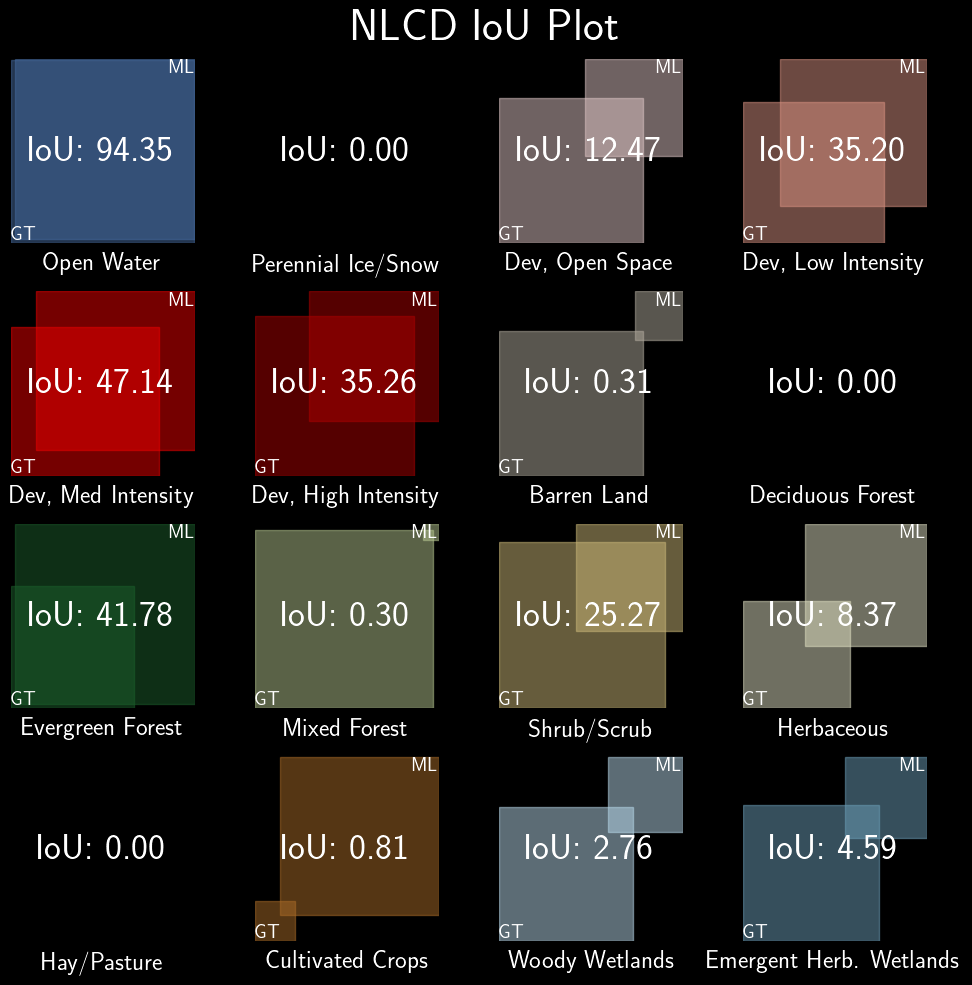

In [212]:
plot_nlcd_iou(gt_array, predict_array, NLCD_COLORS, size_tuple = (10,10))